# LSTM Notebook


In [1]:
import os
import json
import optuna
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load dataset
df = pd.read_csv(r"C:\Users\aryan\Desktop\XAI\XAI_Models\time_series\dataset3\energydata_complete.csv")

                       date    Appliances        lights            T1  \
count                 19735  19735.000000  19735.000000  19735.000000   
unique                19735           NaN           NaN           NaN   
top     2016-01-11 17:00:00           NaN           NaN           NaN   
freq                      1           NaN           NaN           NaN   
mean                    NaN     97.694958      3.801875     21.686571   
std                     NaN    102.524891      7.935988      1.606066   
min                     NaN     10.000000      0.000000     16.790000   
25%                     NaN     50.000000      0.000000     20.760000   
50%                     NaN     60.000000      0.000000     21.600000   
75%                     NaN    100.000000      0.000000     22.600000   
max                     NaN   1080.000000     70.000000     26.260000   

                RH_1            T2          RH_2            T3          RH_3  \
count   19735.000000  19735.000000  19735.0

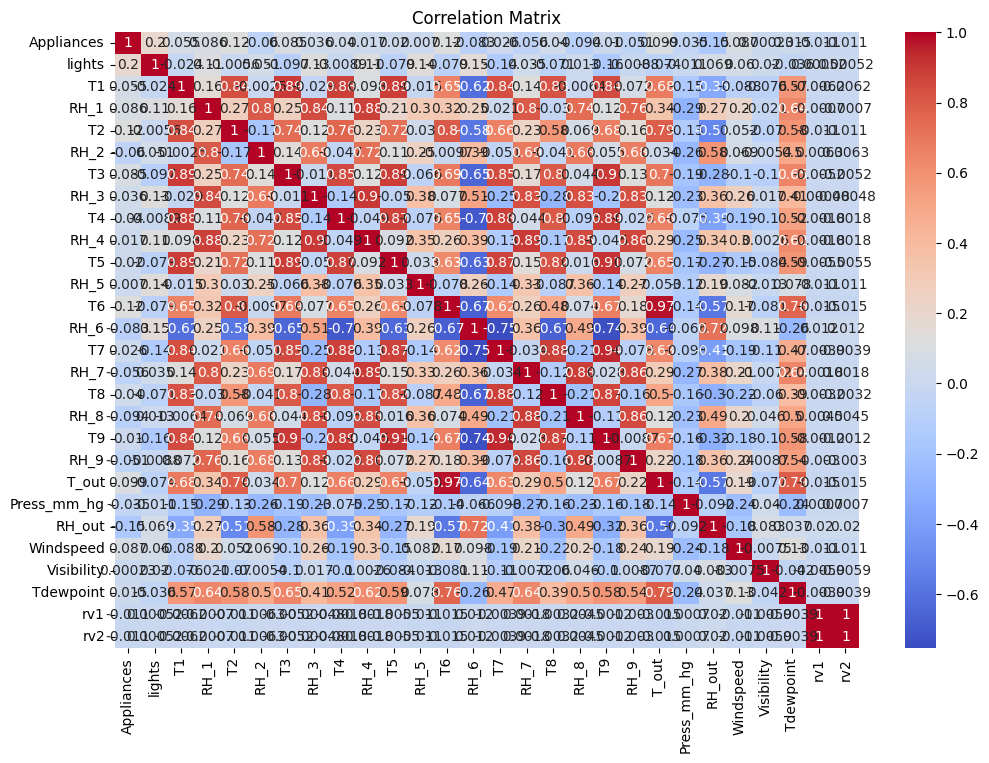

In [3]:
# Display basic statistics
print(df.describe(include='all'))

# Correlation matrix for numerical columns only
numerical_df = df.select_dtypes(include=['int64', 'float64'])
correlation_matrix = numerical_df.corr()
print(correlation_matrix)

# Plotting the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

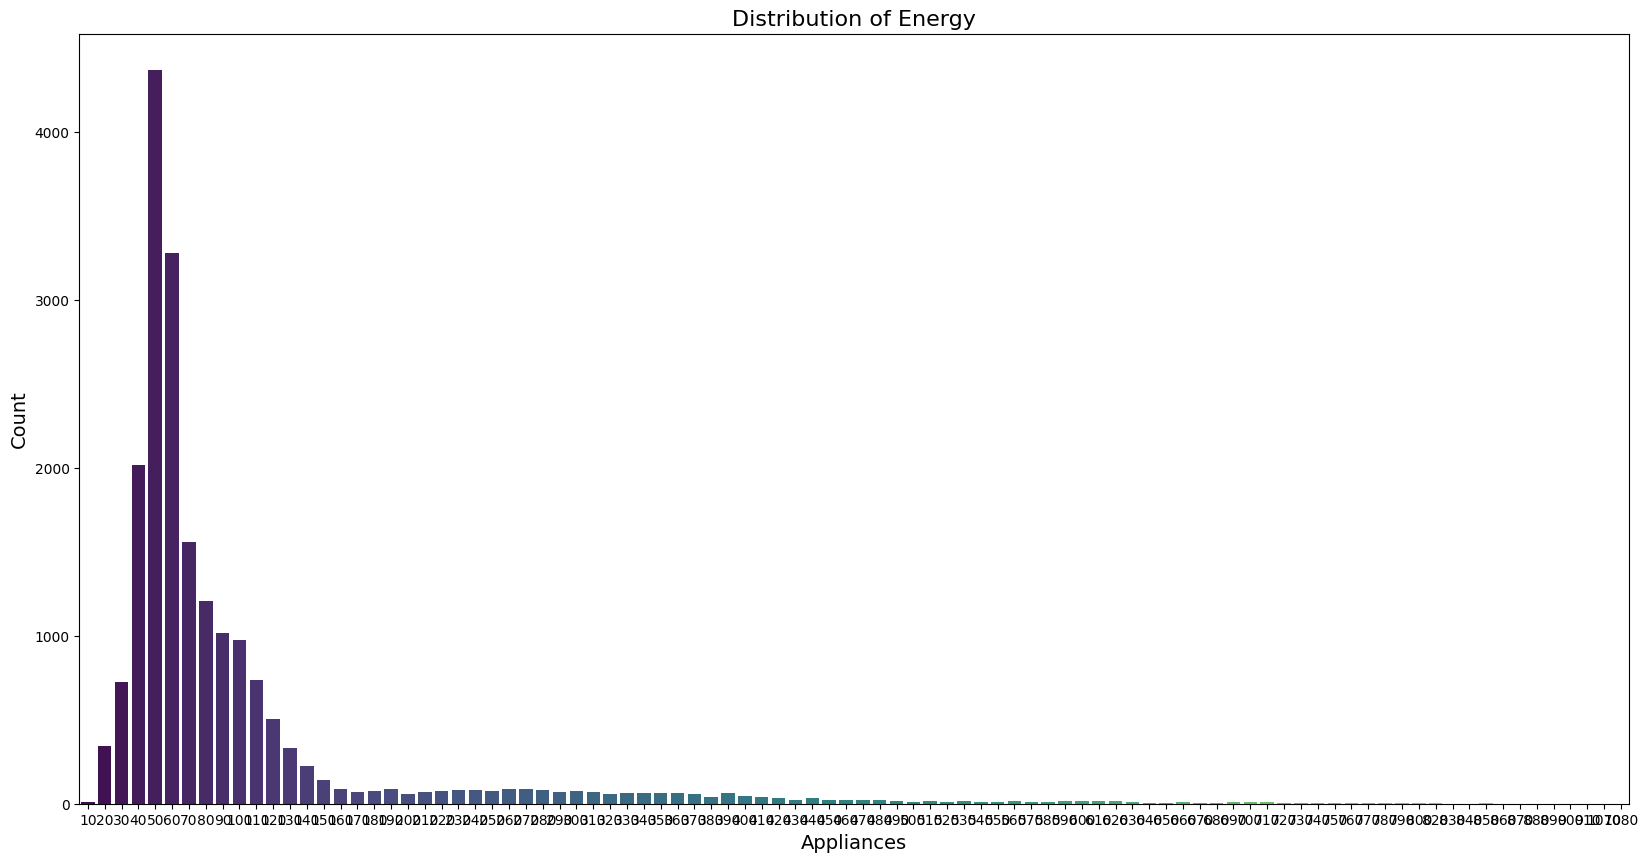

In [4]:
plt.figure(figsize=(20, 10))
sns.countplot(x='Appliances', data=df, palette='viridis')
plt.title('Distribution of Energy', fontsize=16)
plt.xlabel('Appliances', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.show()

In [5]:
df["date"] = pd.to_datetime(df["date"], format="%Y-%m-%d %H:%M:%S")
df = df.groupby("date")["Appliances"].sum().reset_index()
df = df.sort_values("date")
df

,date,Appliances
0,2016-01-11 17:00:00,60
1,2016-01-11 17:10:00,60
2,2016-01-11 17:20:00,50
3,2016-01-11 17:30:00,50
4,2016-01-11 17:40:00,60
...,...,...
19730,2016-05-27 17:20:00,100
19731,2016-05-27 17:30:00,90
19732,2016-05-27 17:40:00,270
19733,2016-05-27 17:50:00,420


In [6]:
# Scaling data
scaler = MinMaxScaler()
df["Appliances"] = scaler.fit_transform(df[["Appliances"]])


In [7]:
# Convert data into sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

seq_length = 10
X, y = create_sequences(df["Appliances"].values, seq_length)

In [8]:
# Split data
split = int(len(X) * 0.8)
X_train, y_train = X[:split], y[:split]
X_test, y_test = X[split:], y[split:]


In [9]:
# Define JSON file for storing best parameters
model_name = "LSTM"
json_file = f"{model_name}.json"

In [10]:
# Objective function for Optuna
def objective(trial):
    model = Sequential([
        LSTM(units=trial.suggest_int("units", 10, 100), return_sequences=True, input_shape=(seq_length, 1)),
        Dropout(trial.suggest_uniform("dropout", 0.1, 0.5)),
        LSTM(units=trial.suggest_int("units_2", 10, 100)),
        Dropout(trial.suggest_uniform("dropout_2", 0.1, 0.5)),
        Dense(1)
    ])
    
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=trial.suggest_loguniform("learning_rate", 0.0001, 0.01)),
                  loss="mse")
    model.fit(X_train, y_train, epochs=10, batch_size=trial.suggest_int("batch_size", 8, 64), verbose=0)
    
    preds = model.predict(X_test)
    return mean_squared_error(y_test, preds)


In [11]:

# Check if hyperparameters exist and are valid
if os.path.exists(json_file):
    with open(json_file, "r") as file:
        best_params = json.load(file)
    
    # If JSON file contains invalid hyperparameters, re-run optimization
    if not all(key in best_params for key in ["units", "dropout", "units_2", "dropout_2", "learning_rate", "batch_size"]):
        study = optuna.create_study(direction="minimize")
        study.optimize(objective, n_trials=50)
        best_params = study.best_params
        with open(json_file, "w") as file:
            json.dump(best_params, file)
else:
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=50)
    best_params = study.best_params
    with open(json_file, "w") as file:
        json.dump(best_params, file)

print("Best Hyperparameters:", best_params)


Best Hyperparameters: {'units': 94, 'dropout': 0.4970729369787982, 'units_2': 100, 'dropout_2': 0.2174208460508459, 'learning_rate': 0.0016680889134733142, 'batch_size': 27}


In [12]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.pipeline import Pipeline
class LSTMPredictor(BaseEstimator, RegressorMixin):
    def __init__(self, units=50, dropout=0.2, units_2=50, dropout_2=0.2, learning_rate=0.001, batch_size=32, epochs=50):
        self.units = units
        self.dropout = dropout
        self.units_2 = units_2
        self.dropout_2 = dropout_2
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.epochs = epochs
        self.model = None
    
    def build_model(self, input_shape):
        model = Sequential([
            LSTM(units=self.units, return_sequences=True, input_shape=input_shape),
            Dropout(self.dropout),
            LSTM(units=self.units_2),
            Dropout(self.dropout_2),
            Dense(1)
        ])
        model.compile(optimizer=keras.optimizers.Adam(learning_rate=self.learning_rate), loss="mse")
        return model
    
    def fit(self, X, y):
        X = X.reshape((X.shape[0], X.shape[1], 1))  # Ensure correct shape
        self.model = self.build_model((X.shape[1], 1))
        self.model.fit(X, y, epochs=self.epochs, batch_size=self.batch_size, verbose=1)
        return self
    
    def predict(self, X):
        X = X.reshape((X.shape[0], X.shape[1], 1))
        return self.model.predict(X).flatten()

# Initialize LSTM model with best hyperparameters
lstm_regressor = LSTMPredictor(
    units=best_params["units"], 
    dropout=best_params["dropout"],
    units_2=best_params["units_2"],
    dropout_2=best_params["dropout_2"],
    learning_rate=best_params["learning_rate"],
    batch_size=best_params["batch_size"],
    epochs=50
)

# Create pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', scaler),
    ('regressor', lstm_regressor)
])

# Fit the pipeline
pipeline.fit(X_train, y_train)

print("LSTM model trained successfully!")


Epoch 1/50
585/585 [==============================] - 9s 10ms/step - loss: 0.0053
Epoch 2/50
585/585 [==============================] - 7s 11ms/step - loss: 0.0044
Epoch 3/50
585/585 [==============================] - 9s 15ms/step - loss: 0.0043
Epoch 4/50
585/585 [==============================] - 9s 15ms/step - loss: 0.0042
Epoch 5/50
585/585 [==============================] - 8s 14ms/step - loss: 0.0042
Epoch 6/50
585/585 [==============================] - 8s 14ms/step - loss: 0.0041
Epoch 7/50
585/585 [==============================] - 8s 14ms/step - loss: 0.0042
Epoch 8/50
585/585 [==============================] - 8s 14ms/step - loss: 0.0041
Epoch 9/50
585/585 [==============================] - 8s 14ms/step - loss: 0.0041
Epoch 10/50
585/585 [==============================] - 8s 14ms/step - loss: 0.0041
Epoch 11/50
585/585 [==============================] - 8s 14ms/step - loss: 0.0041
Epoch 12/50
585/585 [==============================] - 8s 14ms/step - loss: 0.0041
Epoch 13/50
5

In [14]:
from sklearn.model_selection import KFold
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

# Define a function to create the pipeline
def create_pipeline():
    lstm_regressor = LSTMPredictor(
        units=best_params["units"], 
        dropout=best_params["dropout"],
        units_2=best_params["units_2"],
        dropout_2=best_params["dropout_2"],
        learning_rate=best_params["learning_rate"],
        batch_size=best_params["batch_size"],
        epochs=50  # Ensure epochs are appropriate for cross-validation
    )
    pipeline = Pipeline(steps=[
        ('preprocessor', MinMaxScaler()),  # Use a new instance of MinMaxScaler
        ('regressor', lstm_regressor)
    ])
    return pipeline

# Implement manual KFold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = []

for train_idx, val_idx in kf.split(X_train):
    X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
    y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]

    pipeline = create_pipeline()  # Ensure a fresh pipeline for each fold
    pipeline.fit(X_train_fold, y_train_fold)  # Train on training fold

    score = pipeline.score(X_val_fold, y_val_fold)  # Evaluate on validation fold
    cv_scores.append(score)

# Print cross-validation results
print("Cross-validation scores:", cv_scores)
print("Mean cross-validation score:", np.mean(cv_scores))


Epoch 1/50
468/468 [==============================] - 8s 11ms/step - loss: 0.0056
Epoch 2/50
468/468 [==============================] - 7s 14ms/step - loss: 0.0044
Epoch 3/50
468/468 [==============================] - 7s 14ms/step - loss: 0.0042
Epoch 4/50
468/468 [==============================] - 8s 16ms/step - loss: 0.0042
Epoch 5/50
468/468 [==============================] - 11s 24ms/step - loss: 0.0042
Epoch 6/50
468/468 [==============================] - 13s 28ms/step - loss: 0.0041
Epoch 7/50
468/468 [==============================] - 13s 29ms/step - loss: 0.0041
Epoch 8/50
468/468 [==============================] - 8s 17ms/step - loss: 0.0041
Epoch 9/50
468/468 [==============================] - 6s 13ms/step - loss: 0.0041
Epoch 10/50
468/468 [==============================] - 7s 15ms/step - loss: 0.0040
Epoch 11/50
468/468 [==============================] - 8s 16ms/step - loss: 0.0040
Epoch 12/50
468/468 [==============================] - 8s 16ms/step - loss: 0.0040
Epoch 13/5

In [15]:
# Ensure the pipeline is fitted before making predictions
if pipeline.named_steps['regressor'].model is None:
	pipeline.named_steps['regressor'].fit(X_train, y_train)

# Predict on the test data
y_pred = pipeline.predict(X_test)

124/124 [==============================] - 1s 4ms/step


In [16]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Calculate regression metrics
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

print(f"R2 Score: {r2}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")


R2 Score: 0.5758086530305806
Mean Absolute Error (MAE): 0.02666154583765398
Mean Squared Error (MSE): 0.003042378728568663
Root Mean Squared Error (RMSE): 0.055157762178760145


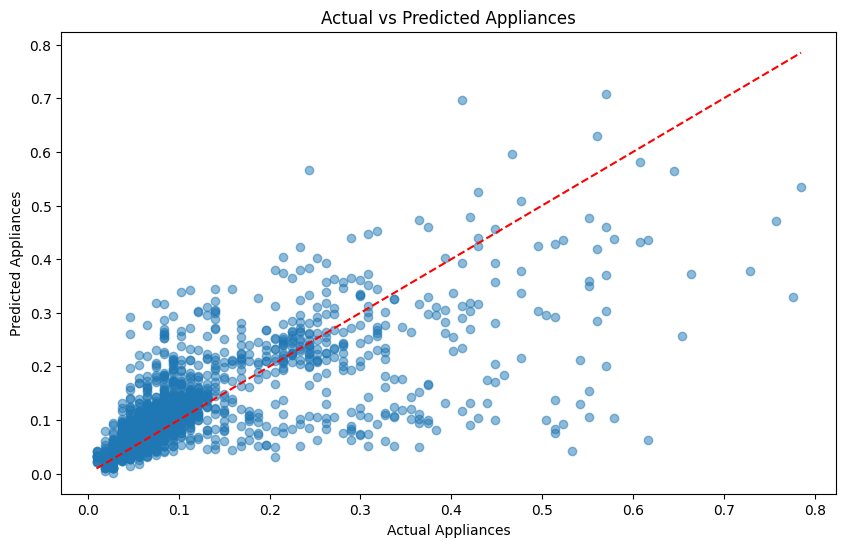

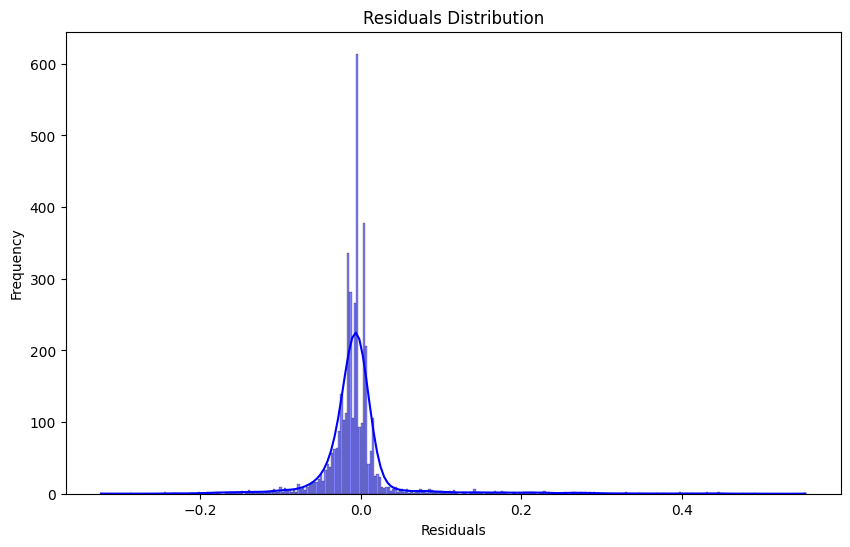

In [17]:
# Scatter plot of actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title('Actual vs Predicted Appliances')
plt.xlabel('Actual Appliances')
plt.ylabel('Predicted Appliances')
plt.show()

# Residual plot
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, color='blue')
plt.title('Residuals Distribution')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

In [18]:
%pip install shap
import shap

# Initialize SHAP Explainer with a subset of the training data
subset_size = 100  # Adjust the subset size as needed
X_train_subset = X_train[:subset_size]

explainer = shap.KernelExplainer(lambda x: pipeline.named_steps['regressor'].model.predict(x.reshape((x.shape[0], x.shape[1], 1))), X_train_subset)

# Generate SHAP values for a subset of the test data
X_test_subset = X_test[:subset_size]
shap_values = explainer.shap_values(X_test_subset)



4/4 [==============================] - 0s 3ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

3194/3194 [==============================] - 10s 3ms/step


c:\Users\aryan\AppData\Local\Programs\Python\Python311\Lib\site-packages\shap\plots\_beeswarm.py:624: UserWarning: The figure layout has changed to tight
  pl.tight_layout(pad=0, w_pad=0, h_pad=0.0)


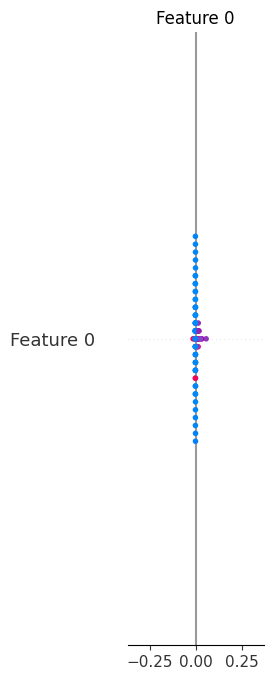

In [19]:
shap.summary_plot(shap_values, X_test_subset.reshape(X_test_subset.shape[0], X_test_subset.shape[1]))


In [20]:
# Store metrics
metrics_data = []
# Append results
metrics_data.append({
    "Model": model_name,
    "R2_Score": r2,
    "Mean Absolute Error": mae,
    "Mean Squared Error": mse,
    "Root Mean Squared Error": rmse
})

# Save metrics to a DataFrame
metrics_df = pd.DataFrame(metrics_data)

# Save to CSV
metrics_df.to_csv("lstm_metrics.csv", index=False)

In [21]:
import joblib

# Assuming the model is trained in your .ipynb session and available in memory
# Replace 'model' with the actual variable holding your trained model
joblib.dump(lstm_regressor, 'lstm.pkl')

print("Model saved successfully as 'lstm.pkl'")


Model saved successfully as 'lstm.pkl'
